In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libs

In [2]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os
# Работа со временем
import time
from scipy.ndimage import zoom
import random


## Giperparams

In [3]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
VAL_SPLIT = 0.1
folder = 'drive/MyDrive/dataset/'


## Service functions

In [59]:
def normalization(dataset):
  max = dataset.max()
  min = dataset.min()
  dataset = (dataset -min)/(max - min)
  return dataset.astype(float)

def load_bscans(folder, height, width): 
    bscans_x = []                       # Список для радарограмм
    bscans_y = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            y = zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T
            # print(folder+'\\'+bscan)
            x = np.zeros_like(y)
            x[:,:] = 0.5
            x[::2, ::2] = y[::2, ::2]
            bscans_x.append(x)
            bscans_y.append(y)

    # Возврат массива-результата
    return np.array(bscans_x), np.array(bscans_y)

def reshape(x, y):
  if len(x) == len(y):
    x = x.reshape([x.shape[0], x.shape[1], x.shape[2], 1])
    y = y.reshape([y.shape[0], y.shape[1], y.shape[2], 1])
  return x, y

def normalization(dataset):
  max = dataset.max()
  min = dataset.min()
  dataset = (dataset -min)/(max - min)
  return dataset.astype(float)

def visualizate_range_dataset_sample():
  rand = random.randint(1, len(x)-1)
  print(rand)
  bscan = x[rand]
  geom = y[rand]
  print(geom.shape)


  fig, ax = plt.subplots(1, 2, figsize = (15,15))
  ax[0].imshow(bscan[:, :,0])
  ax[1].imshow(geom[:, :,0])
  # ax[2].imshow(geom[:, :, 1])
  # ax[1].imshow(npy[:, :, 1])
  plt.show()

def process_images(model,        # обученная модель
                   count = 3     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X_test[indexes]
  orig_geom = y_test[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = np.argmax(model.predict(bscans), axis=-1)
  print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(count, 3, figsize=(25, 15)) 
  for i in range(count):
      # Отображение на графике в первой линии предсказания модели
      axs[0, 0].set_title('Bscan:')
      axs[i, 0].imshow(bscans[i][:,:,0])
      axs[i, 0].axis('off')

      # Отображение на графике во второй линии сегментированного изображения из y_val
      axs[0, 1].set_title('Orig_geom')
      axs[i, 1].imshow(orig_geom[i][:,:,0])
      axs[i ,1].axis('off')

      # Отображение на графике в третьей линии оригинального изображения
      axs[0, 2].set_title('Pred_geom')
      axs[i, 2].imshow(predict[i])
      axs[i ,2].axis('off')

  plt.show() 

## Dataset manipulation

In [35]:
x, y = load_bscans(folder, IMG_HEIGHT, IMG_WIDTH)
x, y = reshape(x, y)
x, y = normalization(x), normalization(y)

484
(128, 128, 1)


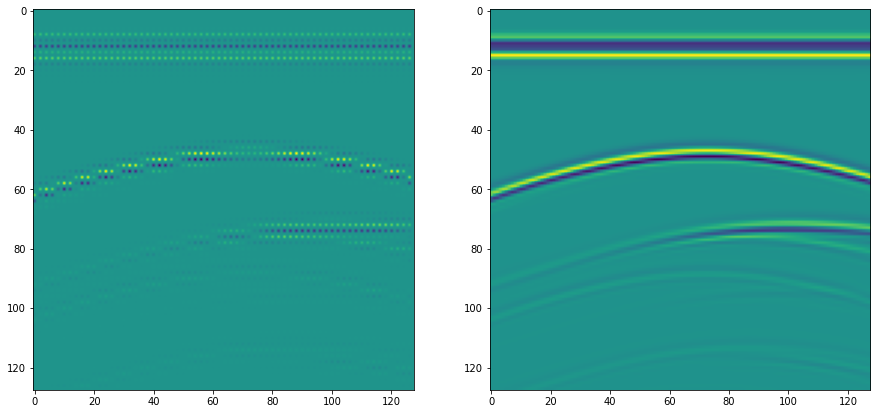

In [37]:
visualizate_range_dataset_sample()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=VAL_SPLIT, 
    random_state=42)

## Нейронка 2 Simple

In [62]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ): 
  
    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(32, (15, 15), padding='same', name='block1_conv1',)(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    # x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    # x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(64, (5, 5), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    # x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='sigmoid', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-6),
                  loss='mse',
                  metrics=['mae'])

    # Возвращаем сформированную модель
    return model



In [63]:
# Обучение модели
model_unet = unet(1, 
                  (IMG_WIDTH, IMG_HEIGHT, 1))

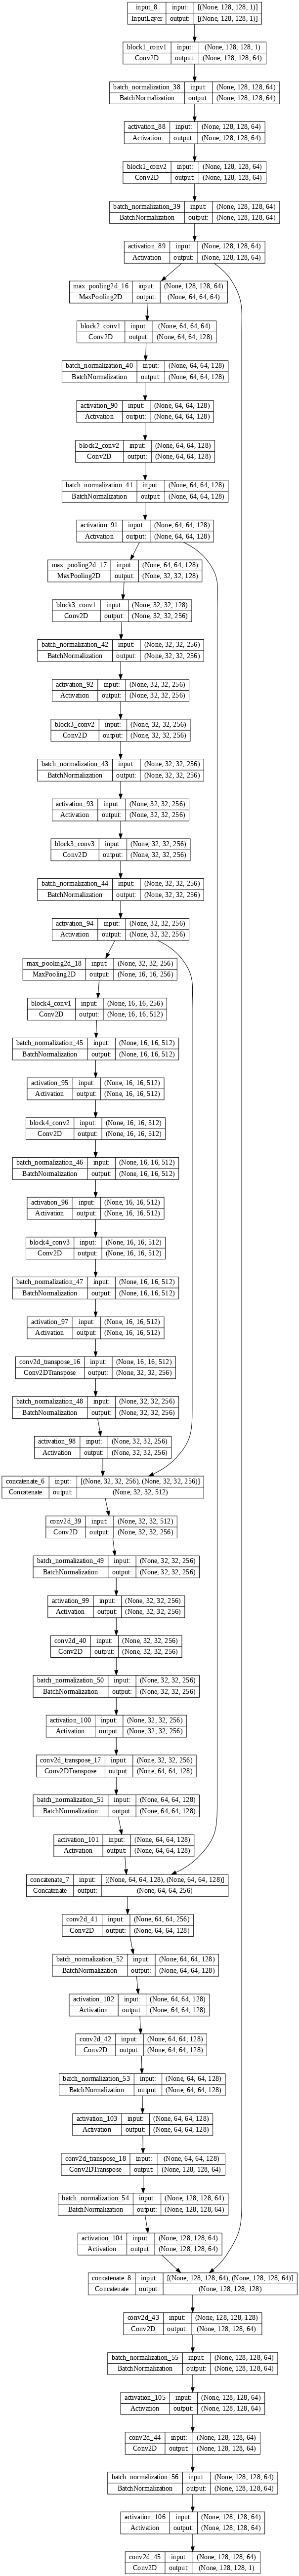

In [64]:
utils.plot_model(model_unet, show_shapes=True, dpi=70)

In [65]:
history = model_unet.fit(X_train, y_train,
                        epochs=50, batch_size=12,
                        validation_data=(X_test, y_test))

Epoch 1/50
65/65 [==============================] - 13s 168ms/step - loss: 0.0187 - mae: 0.0972 - val_loss: 6.6311e-04 - val_mae: 0.0151
Epoch 2/50
65/65 [==============================] - 11s 163ms/step - loss: 0.0116 - mae: 0.0737 - val_loss: 8.6559e-04 - val_mae: 0.0205
Epoch 3/50
65/65 [==============================] - 11s 166ms/step - loss: 0.0081 - mae: 0.0604 - val_loss: 0.0012 - val_mae: 0.0251
Epoch 4/50
65/65 [==============================] - 11s 167ms/step - loss: 0.0057 - mae: 0.0513 - val_loss: 0.0013 - val_mae: 0.0269
Epoch 5/50
65/65 [==============================] - 11s 167ms/step - loss: 0.0042 - mae: 0.0439 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 6/50
65/65 [==============================] - 11s 165ms/step - loss: 0.0033 - mae: 0.0384 - val_loss: 0.0016 - val_mae: 0.0289
Epoch 7/50
65/65 [==============================] - 11s 165ms/step - loss: 0.0028 - mae: 0.0345 - val_loss: 0.0019 - val_mae: 0.0312
Epoch 8/50
65/65 [==============================] - 11s 167ms

1/1 [==============================] - 0s 322ms/step
0 0


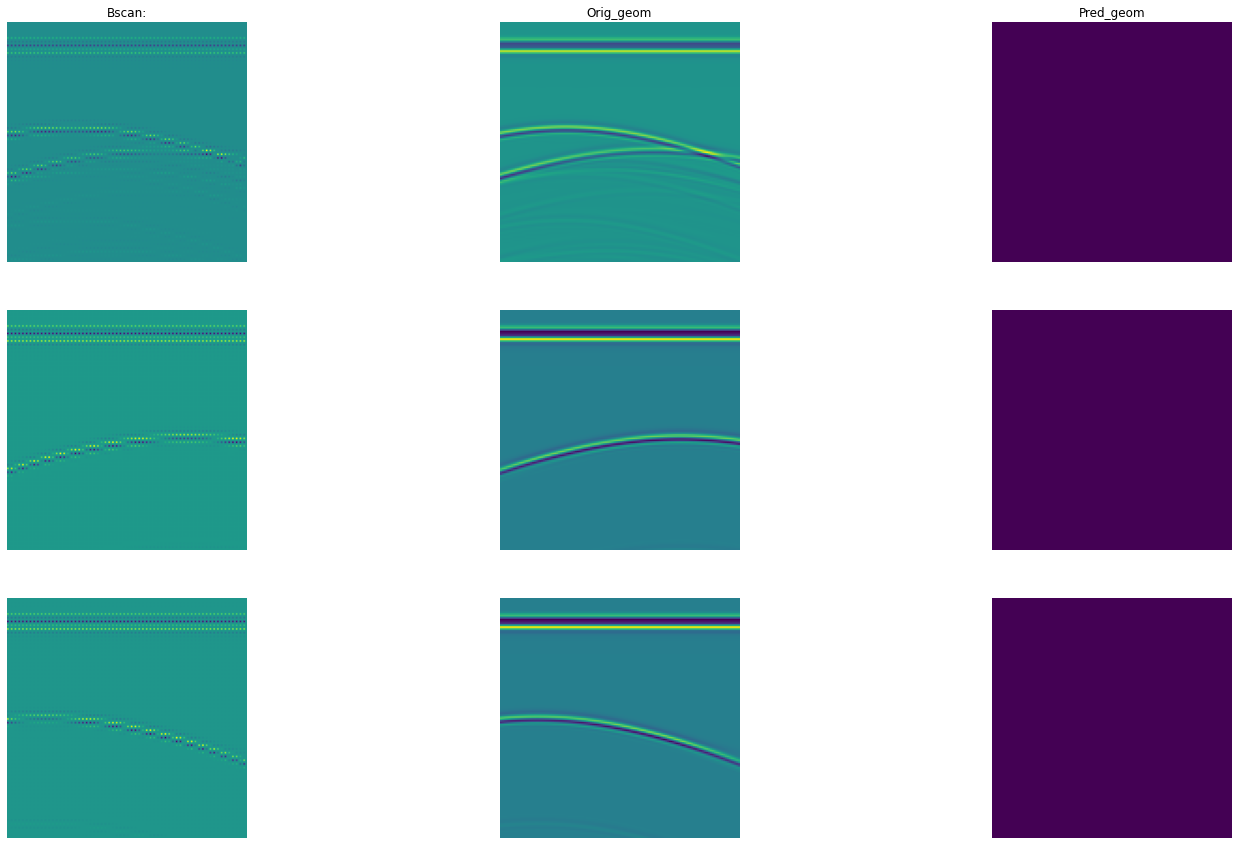

In [66]:
process_images(model_unet)

## Model from publication

In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ): 
  
    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(32, (12, 12), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 32-нейронами
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D(4)(block_1_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D(4)(block_2_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза
    
    # UP 1
    x = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 64-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 32-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count,(3,3), activation='sigmoid', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'
                                           # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-6),
                  loss='mse',
                  metrics=['mae'])

    # Возвращаем сформированную модель
    return model

# Обучение модели
model_unet = unet(1, 
                  (IMG_WIDTH, IMG_HEIGHT, 1))



In [ ]:
# Обучение модели
model_unet = unet(1, 
                  (IMG_WIDTH, IMG_HEIGHT, 1))

In [ ]:
x.min(), x.max()

(0.0, 1.0)

In [ ]:
history = model_unet.fit(X_train, y_train,
                        epochs=50, batch_size=12,
                        validation_data=(X_test, y_test))

Epoch 1/50
65/65 [==============================] - 3s 31ms/step - loss: 6.4959e-04 - mae: 0.0108 - val_loss: 5.6595e-04 - val_mae: 0.0097
Epoch 2/50
65/65 [==============================] - 2s 27ms/step - loss: 6.4624e-04 - mae: 0.0104 - val_loss: 5.6388e-04 - val_mae: 0.0097
Epoch 3/50
65/65 [==============================] - 2s 27ms/step - loss: 6.3501e-04 - mae: 0.0108 - val_loss: 5.3660e-04 - val_mae: 0.0110
Epoch 4/50
65/65 [==============================] - 2s 26ms/step - loss: 5.3516e-04 - mae: 0.0101 - val_loss: 3.7883e-04 - val_mae: 0.0073
Epoch 5/50
65/65 [==============================] - 2s 26ms/step - loss: 4.5513e-04 - mae: 0.0075 - val_loss: 3.7223e-04 - val_mae: 0.0065
Epoch 6/50
65/65 [==============================] - 2s 27ms/step - loss: 4.5325e-04 - mae: 0.0072 - val_loss: 3.7168e-04 - val_mae: 0.0064
Epoch 7/50
65/65 [==============================] - 2s 26ms/step - loss: 4.5270e-04 - mae: 0.0071 - val_loss: 3.7127e-04 - val_mae: 0.0064
Epoch 8/50
65/65 [=========